# Cognitive Decline Prediction Using EEG Data and Machine Learning

## Imports

In [1]:
import mne
from bids import BIDSLayout
import os
import numpy as np
import pandas as pd

### Data Preprocessing

The EEG recordings were exported in .eeg format and transformed to the BIDS-accepted .set format, with a preprocessing pipeline that included applying a Butterworth band-pass filter (0.5-45 Hz), re-referencing, and using Artifact Subspace Reconstruction (ASR) to remove bad data segments. Independent Component Analysis (ICA) was then performed to identify and reject components classified as eye or jaw artifacts, even though some eye movement artifacts remained in the resting state recordings.

In [3]:
data_path = "data/derivatives"

## Load Data

Let's create a dataframe that includes both are participants.tsv data and EEG data.

In [4]:
# Function to load subject data
def load_subject_data(subject_id):
    subject_path = os.path.join(data_path, f"sub-{subject_id:03d}", "eeg", f"sub-{subject_id:03d}_task-eyesclosed_eeg.set")
    # print(f"Trying to load: {subject_path}")  # Debugging line
    raw = mne.io.read_raw_eeglab(subject_path, preload=True)  # Load the .set file
    return raw

In [5]:
'''def load_all_subjects(data_path, num_subjects=88):
    raw_data_list = []
    for subject_id in range(1, num_subjects + 1):
        try:
            raw = load_subject_data(subject_id)  # Load your EEG data here
            raw_data_list.append(raw)
            print(f"Loaded data for subject {subject_id}")
        except FileNotFoundError:
            print(f"Data for subject {subject_id} not found.")
    return raw_data_list'''

'def load_all_subjects(data_path, num_subjects=88):\n    raw_data_list = []\n    for subject_id in range(1, num_subjects + 1):\n        try:\n            raw = load_subject_data(subject_id)  # Load your EEG data here\n            raw_data_list.append(raw)\n            print(f"Loaded data for subject {subject_id}")\n        except FileNotFoundError:\n            print(f"Data for subject {subject_id} not found.")\n    return raw_data_list'

In [6]:
'''raw_data = load_subject_data(1)
if raw_data is not None:
    print(raw_data.info)  # Access the info attribute directly
else:
    print("No data was loaded.")
    
raw_data.plot(n_channels=10, scalings='auto') # Test if data was loaded correctly'''

'raw_data = load_subject_data(1)\nif raw_data is not None:\n    print(raw_data.info)  # Access the info attribute directly\nelse:\n    print("No data was loaded.")\n    \nraw_data.plot(n_channels=10, scalings=\'auto\') # Test if data was loaded correctly'

In [ ]:
# Load participant data
participant_data_path = 'data/participants.tsv'
participant_data = pd.read_csv(participant_data_path, sep='\t')

# Create a list to hold EEG data
eeg_data_list = []

# Load EEG data for each subject and store it in a list
for subject_id in range(1, 89):  # Assuming 88 subjects
    try:
        raw = load_subject_data(subject_id)
        eeg_data_list.append(raw)
    except FileNotFoundError:
        print(f"Data for subject {subject_id} not found.")

# Create a DataFrame for EEG data
eeg_df = pd.DataFrame({
    'participant_id': [f'sub-{str(i).zfill(3)}' for i in range(1, 89)],
    'eeg_data': eeg_data_list
})

# Check if all EEG data has been loaded
print(f"Loaded EEG data for {len(eeg_data_list)} subjects.")

# Merge EEG data with participant information
combined_data = pd.merge(eeg_df, participant_data, on='participant_id')

# Display summary of combined data instead of the entire DataFrame
# For example, display the first few rows of participant information and EEG data shapes
print(combined_data[['participant_id'] + list(participant_data.columns)])  # Adjust according to actual participant data columns

# If you want to see the shape of the EEG data
for index, row in combined_data.iterrows():
    print(f"{row['participant_id']} EEG data shape: {row['eeg_data'].get_data().shape}")

### Encoding Labels

Encode the group labels into numerical format:
Alzheimer's Disease (A) = 0
Frontotemporal Dementia (F) = 1
Healthy Control (C) = 2

In [8]:
group_mapping = {'A': 0, 'F': 1, 'C': 2}
combined_data['Group'] = combined_data['Group'].map(group_mapping)

In [9]:
# Save the combined data to a CSV file
output_csv_path = 'data/combined_eeg_participant_data.csv'
combined_data.to_csv(output_csv_path, index=False)

print(f"Combined data saved to {output_csv_path}")

Combined data saved to data/combined_eeg_participant_data.csv


## Define Feature Extraction Functions

Let's define functions to extract relevant features from your EEG data.

### Bandpower Extraction 

Analyze how different frequency bands (delta, theta, alpha, beta, gamma) change across different brain regions (channels).

In [10]:
def extract_bandpower(raw, freq_bands, n_fft=2048):
    """Extract bandpower features from EEG data."""
    # Compute the Power Spectral Density (PSD)
    spectrum = raw.compute_psd(method='welch', n_fft=n_fft)
    psd_data, freqs = spectrum.get_data(return_freqs=True)

    bandpowers = {}
    for band, (fmin, fmax) in freq_bands.items():
        # Find the indices of frequencies within the specified band
        band_idx = np.where((freqs >= fmin) & (freqs <= fmax))[0]
        # Average the PSD values over the band
        bandpower = np.mean(psd_data[:, band_idx], axis=1)  # Average across all frequencies in the band
        bandpowers[band] = bandpower

    return bandpowers


### Set Indices of Frequencies and Initialize Feature Dictionary

In [11]:
freq_bands = {
    'delta': (0.5, 4),
    'theta': (4, 8),
    'alpha': (8, 13),
    'beta': (12, 25),
    'gamma': (25, 45)
}

# Create a list to hold the feature dictionaries
features_list = []

### Power Spectral Density (PSD)

Using the Welch method is a technique for estimating the power of a signal's frequency components. It provides a way to analyze the distribution of power across different frequencies in a signal, making it useful for identifying dominant frequency components in various applications such as EEG analysis

In [12]:
# Function to compute band power for different frequency bands per channel
def compute_bandpower_per_channel(raw, freq_range):
    # Compute the power spectral density using Welch's method
    spectrum = raw.compute_psd(method="welch")
    # Retrieve the power spectral density data and corresponding frequencies
    data, freqs = spectrum.get_data(return_freqs=True)

    # Find indices of the frequency range
    freq_indices = np.logical_and(freqs >= freq_range[0], freqs <= freq_range[1])
    # Compute the average power in the desired frequency band for each channel
    band_power = np.mean(data[:, freq_indices], axis=1)  # Average power for each channel
    
    return band_power

### Connectivity Measures

Connectivity measures are useful for assessing interactions between different EEG channels or brain regions. Correlation measures linear dependency between signals from different channels.

In [13]:
# Function to compute connectivity between EEG channels
def compute_connectivity(raw):
    """
    Computes the functional connectivity using correlation between channels.
    
    Parameters:
        raw: MNE Raw object containing the EEG data.
        
    Returns:
        Connectivity matrix (correlation coefficients).
    """
    data = raw.get_data()  # Get all channels, shape (n_channels, n_samples)
    connectivity_matrix = np.corrcoef(data)  # Calculate correlation coefficients
    return connectivity_matrix

###  Extract Features and Append to Feature Dictionary

In [ ]:
features_list.clear() #Ensure we reset our feeatures_list
# Iterate over the rows in combined_data
for index, row in combined_data.iterrows():
    raw = row['eeg_data']  # Get the raw EEG data
    bandpower_results = {}

    # Calculate band power for each frequency band for each channel
    for band, freq_range in freq_bands.items():
        bandpower_results[band] = compute_bandpower_per_channel(raw, freq_range)

    # Create a feature dictionary
    features = {
        'participant_id': row['participant_id'],
        'Gender': row['Gender'],
        'Age': row['Age'],
        'Group': row['Group'],
        'MMSE': row['MMSE']
    }

    # Add bandpower features for each channel
    for band, power in bandpower_results.items():
        # Assuming you have 'n_channels' number of channels
        for i, channel_power in enumerate(power):
            features[f'bandpower_{band}_channel_{i+1}'] = channel_power  # +1 for human-readable indexing
        features[f'average_bandpower_{band}'] = np.mean(power)

    # Calculate and add connectivity features
    connectivity_matrix = compute_connectivity(raw)
    
    # For simplicity, you can extract average connectivity or specific values
    features['average_connectivity'] = np.mean(connectivity_matrix)  # Average connectivity across channels

    # Example: Add specific channel correlations if desired
    # features['connectivity_1_2'] = connectivity_matrix[0, 1]  # Correlation between channel 1 and channel 2

    features_list.append(features)


In [ ]:
# Create a new DataFrame for features
features_df = pd.DataFrame(features_list)

# Display the features DataFrame
print(features_df.head())

In [16]:
# Save features to a CSV file
features_df.to_csv('data/extracted_features.csv', index=False)
print("Extracted features saved to extracted_features.csv")

Extracted features saved to extracted_features.csv


In [ ]:
# Display descriptive statistics
print(features_df.describe())

## Data Visualization 

Visually compare the distribution of various bandpower features among different groups of participants using a correlation matrix. We will use the plot to determine which channel recordings and frequency types correlate with our patient groupings.

In [18]:
import seaborn as sns
import matplotlib.pyplot as plt

In [19]:
numeric_features_df = features_df.select_dtypes(include=[np.number])

In [20]:
correlation_matrix = numeric_features_df.corr()

correlation_matrix.to_csv('data/correlation_matrix_df.csv', index=False)

In [ ]:
# Step 2: Extract correlations with "Group" and drop self-correlation
group_correlation = correlation_matrix['Group'].drop('Group')  # Drop self-correlation

group_correlation .to_csv('data/group_correlation _df.csv', index=False)
# Step 3: Get absolute values of the correlations
absolute_group_correlation = group_correlation.abs()

# Step 4: Sort the absolute correlations in descending order
sorted_group_correlation = absolute_group_correlation.sort_values(ascending=False)

# Display the sorted correlations
print(sorted_group_correlation[:21])

In [ ]:
# Define the columns to drop (for both bandpower_gamma and bandpower_beta, plus Age and MMSE)
columns_to_drop = ['Age', 'MMSE']

# Drop the specified columns and rows from the correlation matrix
filtered_corr_matrix = correlation_matrix.drop(columns=columns_to_drop)

# Drop the same rows to keep the matrix symmetric
filtered_corr_matrix = filtered_corr_matrix.drop(index=columns_to_drop)

# Plot the filtered correlation matrix
plt.figure(figsize=(75, 75))
sns.heatmap(filtered_corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True)
plt.title('Correlation Matrix of Features')
plt.show()


### We care about 'Group' correlation in our matrix

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming correlation_matrix is already defined
# Define the columns to drop (for both bandpower_gamma and bandpower_beta, plus Age and MMSE)
columns_to_drop = ['Age', 'MMSE', 'Group']

# Drop the specified columns to create a filtered correlation matrix
filtered_corr_matrix = correlation_matrix.drop(columns=columns_to_drop)

# Select only the "Group" row from the filtered correlation matrix
group_corr_matrix = filtered_corr_matrix.loc[['Group']]

# Plot the correlation matrix for "Group" only
plt.figure(figsize=(75, 50))  # Adjust the figure size as needed
sns.heatmap(group_corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True, cbar=False)
plt.title('Correlation of Features with Group')
plt.show()


## Relevant Feature Extraction

This way, we will only train our model using the top features that provide the highest accuracy.

According to the literature, AD patients exhibit changes in the RBP such as reduced alpha power and increased theta power.

In [ ]:
# Step 1: Extract the top 19 feature names, excluding MMSE
top_features = sorted_group_correlation.index[:21].tolist()

# Step 2: Remove MMSE if it's in the top features
top_features = [feature for feature in top_features if feature != 'MMSE'] # We wonly want to use EEG

# Step 3: Format the list to match your desired output
feature_columns = [f"{feature}" for feature in top_features]

# Print the feature columns in the desired format
formatted_feature_columns = ',\n    '.join(feature_columns)
formatted_output = f"feature_columns = [\n    {formatted_feature_columns}\n]"

print(formatted_output)


## Split  dataset into training and testing subsets

In [ ]:
from sklearn.model_selection import train_test_split

# Select features and target variable
X = features_df[feature_columns]  # Features with selected columns
y = features_df['Group']           # Target variable (you can change this based on your analysis)

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Optional: Print the shapes of the training and testing sets to confirm
print(f"X_train shape: {X_train.shape}, X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}, y_test shape: {y_test.shape}")


In [26]:
# Save training and testing feature sets
X_train.to_csv("X_train.csv", index=False)
X_test.to_csv("X_test.csv", index=False)

# Save training and testing target sets
y_train.to_csv("y_train.csv", index=False)
y_test.to_csv("y_test.csv", index=False)

print("Datasets saved to CSV files.")


Datasets saved to CSV files.


### SMOTE (Synthetic Minority Over-sampling Technique)

Used to generate synthetic samples for the minority class in a dataset. This helps to balance the class distribution, reducing bias in the model's predictions.

In [ ]:
# Check value counts before SMOTE
print("Before SMOTE:")
print(y_train.value_counts())

# Apply SMOTE to resample the training data
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Check value counts after SMOTE
print("\nAfter SMOTE:")
print(y_train_resampled.value_counts())


## XGBoost Model Training and Evaluation

This section demonstrates how to train an XGBoost classifier using the resampled training dataset. The model is fitted on the training data, predictions are made on the test set, and the accuracy of the model is evaluated using the accuracy score metric.

In [ ]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score

# Initialize the XGBoost model with hyperparameters
xgb_model = XGBClassifier(
    learning_rate=0.1,    # Step size for each boosting step
    max_depth=3,          # Maximum depth of a tree
    n_estimators=100,     # Number of boosting rounds (trees)
    random_state=42,
    objective='multiclass:softmax'  # Assuming binary classification; adjust for multiclass if needed
)

xgb_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = xgb_model.predict(X_test)

# Evaluate the XGBoost model
accuracy = accuracy_score(y_test, y_pred)
print(f"XGBoost model accuracy: {accuracy:.2f}")


XGBoost model accuracy: 0.61


### Confusion Matrix

 This will show the count of true positives, false positives, true negatives, and false negatives for each class, giving insight into how well each class is being predicted.

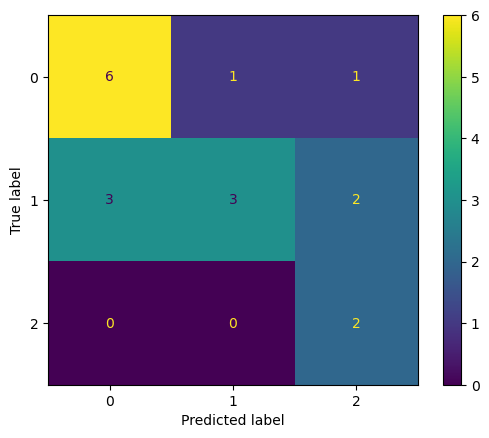

In [161]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()


### Classification Report

In [ ]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred))

### ROC AUC Score

Measures the model's ability to distinguish between classes.

In [45]:
from sklearn.metrics import roc_auc_score
y_pred_proba = xgb_model.predict_proba(X_test)
roc_auc = roc_auc_score(y_test, y_pred_proba, multi_class='ovr')
print(f"ROC AUC Score: {roc_auc:.2f}")


ROC AUC Score: 0.71


### Cross-Validation

In [ ]:
from sklearn.model_selection import cross_val_score
cv_scores = cross_val_score(xgb_model, X_train_resampled, y_train_resampled, cv=20)
print(f"Cross-validation scores: {cv_scores}")
print(f"Mean CV accuracy: {cv_scores.mean():.2f}")


### Feature Importance

In [ ]:
import matplotlib.pyplot as plt
importances = xgb_model.feature_importances_
plt.barh(X_train_resampled.columns, importances)
plt.title('Feature Importances')
plt.show()


### Precision-Recall Curve

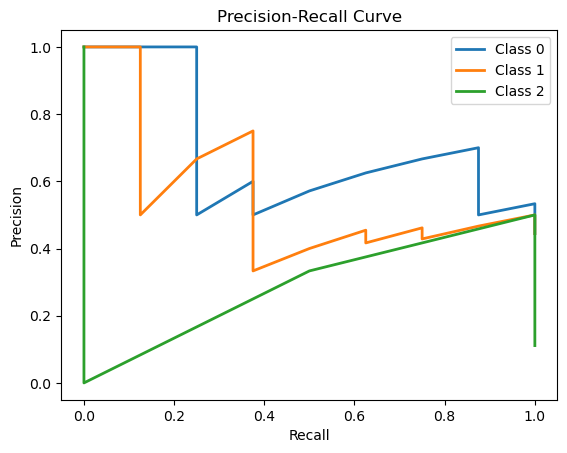

In [173]:
from sklearn.metrics import precision_recall_curve
from sklearn.preprocessing import label_binarize
y_test_bin = label_binarize(y_test, classes=[0, 1, 2])
y_score = xgb_model.predict_proba(X_test)
for i in range(len(y_score[0])):
    precision, recall, _ = precision_recall_curve(y_test_bin[:, i], y_score[:, i])
    plt.plot(recall, precision, lw=2, label=f'Class {i}')
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.legend()
plt.title("Precision-Recall Curve")
plt.show()


## Hyperparameter Tuning

In [46]:
from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

# Define the model
xgb_model = XGBClassifier(random_state=42)

# Define the parameter grid
param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0]
}

# Set up the RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=param_grid,
    n_iter=20,  # Number of random combinations to try
    scoring='f1_weighted',  # Scoring metric, can be 'accuracy', 'precision', etc.
    cv=20,  # Number of cross-validation folds
    random_state=42,
    verbose=1,
    n_jobs=-1  # Use all available cores
)

# Fit the RandomizedSearchCV to the training data
random_search.fit(X_train_resampled, y_train_resampled) #Avoid overfitting by not training it on the whole data set 

# Get the best parameters and score
print("Best parameters found: ", random_search.best_params_)
print("Best F1 score found: ", random_search.best_score_)

Fitting 20 folds for each of 20 candidates, totalling 400 fits
Best parameters found:  {'subsample': 0.6, 'n_estimators': 200, 'max_depth': 3, 'learning_rate': 0.01, 'colsample_bytree': 0.6}
Best F1 score found:  0.68225


In [47]:
# Train a new model with the best parameters
best_xgb_model = random_search.best_estimator_

# Make predictions on the test set
y_pred = best_xgb_model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")


Accuracy: 0.50
Precision: 0.51
Recall: 0.50
F1 Score: 0.47


In [215]:
# Detailed classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))


Classification Report:
              precision    recall  f1-score   support

           0       0.56      0.62      0.59         8
           1       0.50      0.25      0.33         8
           2       0.40      1.00      0.57         2

    accuracy                           0.50        18
   macro avg       0.49      0.62      0.50        18
weighted avg       0.51      0.50      0.47        18



## Conclusion

We can conclude from our hyperparameter tuning that despite potentially achieving higher F1 scores, this would lead to overfitting as our model's performance on the test data remains poor. 

If we perform cross-validation accross our original data set, we get an average CV score of 65%. 

Our model is able to determine whether or not our subject is healthy or not, but struggles when determining whether they have AD or Dementia.